# Improved WordGraph2Vec Model with Skip Gram and Negative Sampling

Tha main idea of the Word2Vec model code is taken from the Tensorflow documentation at: https://www.tensorflow.org/tutorials/text/word2vec is based on Efficient estimation of word representations in vector space and Distributed representations of words and phrases and their compositionality from Mikolov et al\.

## Processing Text Corpus

Since working with a large corpus is not feasible due to computational contraints I tried to create a simple text corpus merging different resources also including training files of the NER test model and some other files that I found on the internet:

A list of files is available below for download:


1.   text8 file - http://mattmahoney.net/dc/textdata.html
2.   NER Dataset You can find it in the uploaded files
3.   Conll Dataset

You can skip the following part if you already have a text corpus preprocessed.



Generate a file from NER datasets Conll003 Corpora and another dataset which i dont remember the name but whatever :)

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

Since I am using Google Colab I had to upload the files in the cloud using the following command because drag and drop is not working. If you are testing locally please ignore the following line.

In [ ]:
# Upload the data to google cloud in case the drag-drop upload is not working.
from google.colab import files
dataset_file_dict = files.upload()

In [ ]:
import pandas as pd
ner_data = pd.read_csv("/content/ner_dataset.csv", encoding = "ISO-8859-1", error_bad_lines=False)

In [ ]:
ner_data = ner_data.fillna(method='ffill')

Concatenate sentences from the NER and Conll Dataset
Reference: https://www.kaggle.com/anhkhoado/ner-bilstm

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[w for w in s["Word"].values.tolist()]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(ner_data)
ner_sequence = getter.sentences
ner_text = ''
for sentence in ner_sequence:
    ner_text += ' '.join(sentence)

Read data from Conll2003 dataset (Weird format though...)

---



In [ ]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0]))
    return final

In [ ]:
base_path = '/content/'
train_samples = load_sentences(base_path + 'conll-train.txt')
test_samples = load_sentences(base_path + 'conll-test.txt')
valid_samples = load_sentences(base_path + 'conll-valid.txt')
conll_samples = train_samples + test_samples + valid_samples
conll_text = ''
for sentence in conll_samples:
    conll_text += ' '.join(sentence)

Combine this data with text and wiki text.

In [ ]:
# Shakespear text
with open('/content/shakespeare.txt', 'r') as f:
    shakespeare_text = f.read()

Reference to download file code: https://github.com/Hironsan/awesome-embedding-models/blob/master/notebooks/skip-gram_with_ng.ipynb




In [ ]:
# Some text data from wikipedia
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'content'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)

Text8 Dataset: 31.4MB [00:42, 745kB/s]                            


In [ ]:
with open('content/text8') as f:
    wiki_text = f.read()
corpus_text = wiki_text

In [ ]:
# corpus_text = wiki_text + ' ' + conll_text + ' ' + shakespeare_text + ' ' + ner_text
corpus_text = conll_text + ' ' + shakespeare_text + ' ' + ner_text

Some text preprocessing
Reference: https://github.com/Hironsan/awesome-embedding-models/blob/master/notebooks/skip-gram_with_ng.ipynb and https://jdvala.github.io/blog.io/thesis/2018/05/04/Preprocessing-English-Text.html

In [ ]:
import re
from collections import Counter
def preprocess(text):
    # Replace punctuation with tokens so we can use them in our model
    # I dont think this would improve the performance
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    return trimmed_words

In [ ]:
def pun(text):
    """Return punctuations from text"""
    table = str.maketrans("","", string.punctuation)
    t = text.translate(table)
    return t

In [ ]:
def remove(text):
    """Returns text with all the filtering necessary"""
    t = re.sub(r"(\d+\.\d+)","",text)
    #t = re.sub(r"(\d+th?|st?|nd?|rd?)","", t)
    t = re.sub(r"\d{2}.\d{2}.\d{4}","",t)
    t = re.sub(r"\d{2}\/\d{2}\/\d{4}","",t)
    t = re.sub(r"\d{2}(\/|\.)\d{2}(\/|\.)\d{2}","",t)
    t = re.sub(r"($|€|¥|₹|£)","",t)
    t = re.sub(r"(%)","",t)
    t = re.sub(r"\d+","",t)
    t = re.sub(r"\n","",t)
    t = re.sub(r"\xa0", "", t)
    return t

In [ ]:
def extras(sentences):
    """Returns text after removing some extra symbols"""
    t = re.sub(r"\"|\—|\'|\’","",sentences)
    word_list = t.split()
    for index, word in enumerate(word_list):
        if len(word) <=1:
            del word_list[index]
    t = ' '.join(word_list)

    return t

In [ ]:
# Stop word removal
def stop_word(sentence):
    list_ = []
    stop_words = stopwords.words('english')
    words_list = sentence.split()
    for word in words_list:
        if word not in stop_words:
            list_.append(word)
    return ' '.join(list_)

In [ ]:
corpus_text = corpus_text.lower().strip()

In [ ]:
import spacy
from nltk.tokenize import sent_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Sentence tokenize the text
sent_tokenized = sent_tokenize(corpus_text)

In [ ]:
# Removing stop words
# t1 = [lemmatizer(sent) for sent in sent_tokenized]

In [ ]:
# lemmatization
t2 = [stop_word(sent) for sent in sent_tokenized]

In [ ]:
# Removing all the unnecessary things from the text
t3 = [remove(line) for line in t2]

In [ ]:
# Removing punctuations
t4 =[pun(line.lower()) for line in t3]

In [ ]:
t5 = [extras(sent) for sent in t4]

In [ ]:
# Write preprocessed text to a file not to do it again as it really takes too long
preprocessed_text_file = open("preprocessed_corpus.txt", "w")
corpust_sentence_processed = ''
for sent in t5:
    corpust_sentence_processed += ''.join(sent)
n = preprocessed_text_file.write(corpust_sentence_processed)
preprocessed_text_file.close()

## Word Graph Construction

In [ ]:
# Upload the data to google cloud in case the drag-drop upload is not working.
# This was the case on my side
from google.colab import files
dataset_file_dict = files.upload()

Saving shakespeare.txt to shakespeare.txt


In [ ]:
with open('/content/preprocessed_corpus.txt', 'r') as f:
    corpus_text = f.read()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    def split_words(word, occurrence):
        word_list = word.split()
        return [word_list[0], word_list[1], occurrence]
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [split_words(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # bigrams = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
weighted_edges = get_top_ngram(t5, 2)

In [ ]:
weighted_edges[0]

['anarchism', 'originated', 1]

In [ ]:
def get_nodes(doc):
    # print(doc[:500])
    split_text = doc.split()
    unique_words = set(split_text)
    return unique_words

In [ ]:
nodes = get_nodes(corpus_text)
VOCAB_SIZE = len(nodes)

In [ ]:
print('Unique Words:', len(nodes))
print('Cooccurrences: ', len(weighted_edges))

Unique Words: 253702
Cooccurrences:  5407314


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
# Comment this line if you need to download the packages
# nltk.download('punkt')
# nltk.download('stopwords')


"""
A helper class to construct a graph (Schenker’s work):
- Nodes = unique words in corpus
- Remove all words with occurrence less than 100
- Directed Weighted Edges = co-occurrence of words (bi-grams)
https://towardsdatascience.com/structuring-text-with-graph-representations-41dd4f2a3ab3
Reference: Diogo A.P. Nunes Oct 11, 2021 Medium at LINK
"""


def preprocess_document(sentences, sentence_spliter='.?!;', word_spliter=' ', punct_mark=','):
    # Improve: Do this before building the graph maybe it will improve the speed...
    # lowercase all words and remove trailing whitespaces
    # document = document.lower().strip()

    # remove unwanted punctuation marks
    # for pm in punct_mark:
    #     document = document.replace(pm, '')

    # get list of sentences which are non-empty
    # sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    # sentences = nltk.tokenize.sent_tokenize(document)

    # Improve : Remove puncutatuon can be faster
    # sentences = [sent.translate(str.maketrans('', '', punctuation)) for sent in sentences if sent != '']
    # get list of sentences which are lists of words

    document = []
    # stop_words = set(stopwords.words('english'))
    # Improve: You can remove stopword faster with vectorization...
    for sent in sentences:
        # words = sent.strip().split(word_spliter)
        words = nltk.tokenize.word_tokenize(sent)
        # filtered_words = [w for w in words if not w.lower() in stop_words]
        document.append(words)
    # print(document)
    return document


def get_entities(document):
    # This is fucking slow use get_nodes() improved version

    # in our case, entities are all unique words
    # Imporve it use counter - vectorization - tokenization
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words


def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams


def get_weighted_edges(document):
    # Use get_top_n_grams instead as it is more efficient and faster

    # in our case, relations are bigrams in sentences
    # weights are number of equal bigrams
    # use a dict to store number of counts
    bigrams = {}
    for sent in document:
        for i in range(len(sent) - 1):
            # transform to hashable key in dict
            pair = str([sent[i], sent[i + 1]])
            if pair not in bigrams.keys():
                # weight = 1
                bigrams[pair] = 1
            else:
                # already exists, weight + 1
                bigrams[pair] += 1
    # convert to NetworkX standard form each edge connecting nodes u and v = [u, v, weight]
    weighted_edges_format = []
    for pair, weight in bigrams.items():
        # revert back from hashable format
        w1, w2 = eval(pair)
        weighted_edges_format.append([w1, w2, weight])
    return weighted_edges_format


def build_graph(doc, preprocess=True):
    # preprocess document for standardization
    pdoc = doc
    if preprocess:
        pdoc = preprocess_document(doc)
    # get graph nodes
    nodes = get_entities(pdoc)
    # get graph edges
    edges = get_relations(pdoc)
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G


def build_weighted_digraph(document, preprocess=True):
    # preprocess document for standardization
    pdoc = document
    if preprocess:
        pdoc = preprocess_document(document)
    # get graph nodes
    nodes = get_entities(pdoc)
    # get weighted edges
    weighted_edges = get_weighted_edges(pdoc)
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    return G


def fast_build_weighted_digraph(nodes, weighted_edges):
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    return G


def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10, 10))
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True, arrows=True, connectionstyle='arc3, rad = 0.1')
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # edge_labels = G.edges.data().items()
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    # plot the title (if any)
    plt.title(title)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


DiGraph with 21 nodes and 34 edges


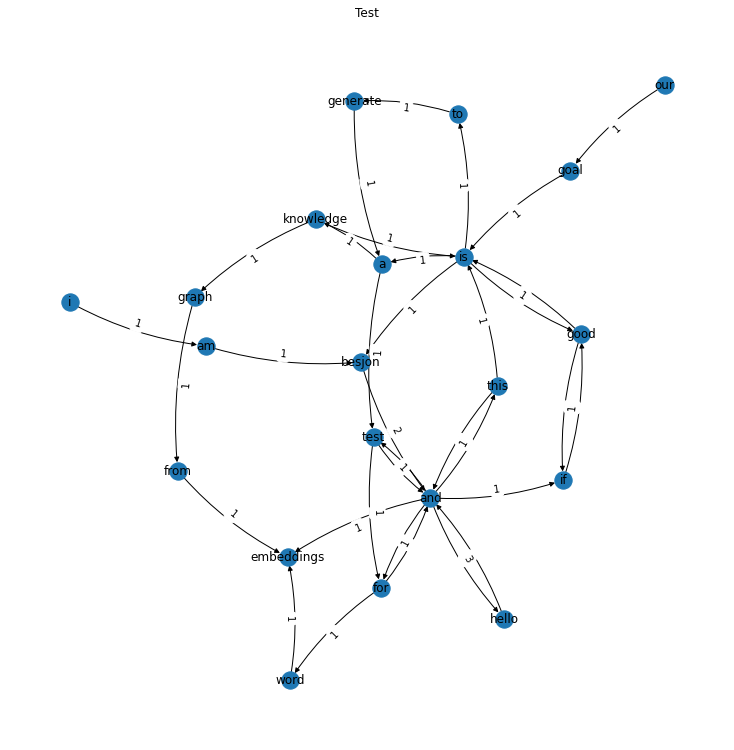

In [ ]:
test = "Hello. I am Besjon and this is a test for word embeddings. " \
    "Our goal is to generate a Knowledge graph from embeddings. " \
    "Knowledge is good if good is Besjon and hello and hello and " \
    "hello hello and this and test and for and embeddings. and if"
G = build_weighted_digraph(test)

f = open(text_file, "r")
# with open(".\\data\\enwiki-latest-pages-articles_preprocessed.txt") as file:
    # first_line = f.readline()
    # head = [next(file) for x in range(10)]
    # print(head)
test = f.read(100000000)
# Remove self loop in the Graph
G.remove_edges_from(nx.selfloop_edges(G))
print(G)
# Plot is not working in colab due to package mixed configurations
plot_graph(G, title='Test')


### Generate a Graph from our corpus

In [ ]:
G = fast_build_weighted_digraph(nodes, weighted_edges)
# Remove self loops in the Graph
G.remove_edges_from(nx.selfloop_edges(G))
# Remove edges with weight less than X=5
edge_weights = nx.get_edge_attributes(G, 'weight')
G.remove_edges_from((e for e, w in edge_weights.items() if w < 6))
print(G)

DiGraph with 253702 nodes and 163766 edges


In [ ]:
# Store graph to speed up initialization
nx.write_gpickle(G,'/content/corpus_graph.gpickle')

In [ ]:
# Restore Graph from the file
G = nx.read_gpickle('/content/corpus_graph.gpickle')
print(G)

DiGraph with 282538 nodes and 182513 edges


## WordGraph2Vec Embbedings

Reference: https://www.tensorflow.org/tutorials/text/word2vec

* Continous Skip-gram Model predicts words within certain range before and after current word in the same sentence.

While a bag-of-words model predicts a word given the neighboring context, a skip-gram model predicts the context (or neighbors) of a word, given the word itself

### Skip-gram and Negative Sampling
- n-grams that allow tokens to be skipped
- context of a word can be represented through a set of skip-grams pairs of (target_word, context_word) context_word appears in neighboring context of target_word.

The training objective of the skip-gram model is to maximize the probability of predicting context words given the target word. The basic skip-gram formulation defines this probability using the softmax function.

In [ ]:
import io
import re
import string
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# Load the TensorBoard notebook extension
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

## Generate a KG from the text corpus to enhance semantic relations of the Word2Vec Model.

In [ ]:
def selectCWords(sentence, M):
    # Select M context words words from a sentence at random
    return random.sample(sentence.split(), M)

In [ ]:
def selectNWords(N, target, G, R):
    # Select N words from Graph in radius R from target word
    if target not in G:
        return []
    # It returns a subgraph of depth R
    graphT = nx.ego_graph(G, target, radius=R, center=True)
    # plot_graph(graphT)
    sortedGraph = sorted(graphT.edges(target, data=True), key=lambda t: t[2].get('weight', 1))
    # Get only the edges that are connected to the target word (out-edges)
    # targetOutEdges = graphT.edges(target, data='weight')
    # print(targetOutEdges)

    # Select some words from the graph (N words that had most occurences)
    graphWords = sortedGraph[-N:]
    # print('Words from Graph: ', graphWords)

    selectedGraphWords = [edges[1] for edges in graphWords]
    # Should also give a label to them
    return selectedGraphWords

`skipgrams` returns all positve skip-gram pairs by sliding over a given window span.  

To produce negative samples for training sample random words from the vocabulary. Sample n number of negative samples for a given target word in a window.

For a positive skip-gram there are n negative sampled context words (do not appear in window size neighborhood of target word)

Batch 1 positive context word and n negatve context words into 1 tensor => This produces a  set of positive skip-grams and negative samples

<b>Skip-Gram Sampling Table</b>

Datsets - large vocabulary with higher number of more frequent words (stopwords) Training examples sampled commonly occurring words (the, is, on) don't add information for the model.

Subsample of frequent words to improve embedding quality

`tf.keras.preprocessing.sequence.skipgrams` accepts a sampling table argument to encode probabilities of sampling any token.

`tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank based probabilistic sampling table and pass it to `skipgrams` function.

```
> sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
```

sampling_table[i] denotes = probability of sampling the i-th most common word in a dataset.



In [ ]:
# Otherwise we need to implement sth like this that discard words based
# on the probability / frequencies values...

# threshold = 1e-5
# word_counts = Counter(int_words)
# total_count = len(int_words)
# freqs = {word: count/total_count for word, count in word_counts.items()}
# p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# # discard some frequent words, according to the subsampling equation
# # create a new list of words for training
# train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
# print(train_words[:30])

## Generate training data

Called on list of vectorized sentences obtained from any text dataset.

Sampling table is build before sampling skip-gram word pairs.


In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
  stop_words = set(stopwords.words('english'))
  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    # Add sampling_table=sampling_table, to discard some of the sampled pairs
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          window_size=window_size,
          sampling_table=sampling_table,
          shuffle=True,
          negative_samples=0)
    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      # print(f"Context and Target: ({target_word}, {context_word}): ({inverse_vocab[target_word]}, {inverse_vocab[context_word]})")
      context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)
      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

The improved training data gerneration for Improved WordGraph2Vec

In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_enhanced_relation_training_data(sequences, window_size, num_ns, vocab_size, seed, select_M=2, select_T=2, R=1):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []
  targetGraph, contextGraph, labelsGraph = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
  stop_words = set(stopwords.words('english'))
  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):
    sentence = ''
    for s in sequence:
        sentence += inverse_vocab[s] + ' '
    # print('Sentence: ', sentence)
    # Generate positive skip-gram pairs for a sequence (sentence).
    # Add sampling_table=sampling_table, to discard some of the sampled pairs
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          window_size=window_size,
          shuffle=True,
          sampling_table=sampling_table,
          negative_samples=0)
    # print('Pos skip grams: ', positive_skip_grams)
    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    M=0
    for target_word, context_word in positive_skip_grams:
      # print(f"Context and Target: ({target_word}, {context_word}): ({inverse_vocab[target_word]}, {inverse_vocab[context_word]})")

      if inverse_vocab[context_word] not in stop_words:
        # print(f"Target context word search in graph: ({inverse_vocab[context_word]})")
        if M % select_M != 0:
            graphWords = selectNWords(select_T, inverse_vocab[context_word], G, R)
            targetGraph.append(context_word)
            # print('Graph Words', graphWords)
            graphToInt = [inverse_vocab.index(word) for word in graphWords]
            for i in graphToInt:
                graph_context_class = tf.expand_dims(tf.constant([i], dtype="int64"), 1)
                graph_negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                    true_classes=graph_context_class,
                    num_true=1,
                    num_sampled=num_ns,
                    unique=True,
                    range_max=vocab_size,
                    seed=SEED,
                    name="negative_sampling")
                # Build context and label vectors (for one target word)
                graph_negative_sampling_candidates = tf.expand_dims(graph_negative_sampling_candidates, 1)
                graph_context = tf.concat([graph_context_class, graph_negative_sampling_candidates], 0)
                graph_label = tf.constant([1] + [0]*num_ns, dtype="int64")
                targets.append(context_word)
                contexts.append(graph_context)
                labels.append(graph_label)
                M += 1

      context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)
      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

### Defining Training Data
---
Since there is no more punctuation and stuff there is no point on spliting the sentences as \n or using punctuations. Maybe as a workaround we can define a sentence as a group of 25 words each. I know that this might not work properly but unfortunately wiki text does not contain any punctuation or new line. The text seems to be preprocessed (new lines removed, numbers converted to strings(names) and everything else cleaned) It does not make any sense to continue to find a way how to process the text and tokenize it into sentence...


> Check: wiki_text

In [ ]:
import textwrap
# 120 character long ~ average of 10 - 15 words in English for each sentence
# Unfortunately no guarantee that sentence would make a lot of sense
lines = textwrap.wrap(corpus_text, 120, break_long_words=False)

In [ ]:
# print(len(lines))
# print(lines[1003],'\n', lines[1004], '\n', lines[1005], '\n',lines[1006], '\n', lines[1007])

# Write this to a text file based on new lines:
with open("line_corpus.txt", "w") as f:
    f.write('\n'.join(lines))

### Preparing trainng data for Word2Vec

In [ ]:
# path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
path_to_file = '/content/line_corpus.txt'

In [ ]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [ ]:
## Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# Define the vocabulary size and number of words in a sequence.
vocab_size = VOCAB_SIZE # len(nodes)
sequence_length = 20

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
vectorize_layer.adapt(text_ds.batch(1024))

In [ ]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()

In [ ]:
# The vectorize_layer can now be used to generate vectors for each element in the text_ds.
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

Now we have a `tf.data.Dataset` of integer encoded sentences. To prepare the dataset for training a Word2Vec model, flatten the dataset into a list of sentence vector sequences.

Iterate over each sequence in dataset to produce positive and negative examples.

In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())

In [ ]:
print(len(sequences))

654587


In [ ]:
for seq in sequences[:2]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 5114  2953   100  3008    13    16    49   612   357 10454    54 27662
    38   722 14950     0     0     0     0     0] => ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', '', '', '', '', '']
[62401    67   722  3450   100    97    16 10609   117  1191   335    16
  2602   249  3546   579     0     0     0     0] => ['culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe', 'act', 'used', 'violent', 'means', 'destroy', 'organization', '', '', '', '']


`sequences` is now a list of encoded sentences. Call the generate_training_data_function to generate training examples for Word2Vec model.

Iterates over each word from each sequence to collect positive and negative context words.

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=3,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

In [ ]:
print(targets[0], contexts[0], labels[0])
print(inverse_vocab[targets[0]])
print(inverse_vocab[1425], inverse_vocab[908], inverse_vocab[53], inverse_vocab[7341], inverse_vocab[216])

12257 [ 388  908   53 7341  216] [1 0 0 0 0]
disagreed
peter religious prime hampering weapons


### Configure dataset for performance

Perform efficient batching for large number of training examples

tf.data.Dataset object of (targe_word, context_word), (label) elements to train your Word2Vec model.

In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


A function to download embeddings

In [ ]:
def download_embedding_file(word2vec, vectorize_layer, title=''):
    weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
    vocab = vectorize_layer.get_vocabulary()

    # Create and save the vectors and metadata file.
    out_v = io.open(f'vectors_{title}.tsv', 'w', encoding='utf-8')
    embeddings_file = io.open(f'embeddings_{title}.tsv', 'w', encoding='utf-8')
    out_m = io.open(f'metadata_{title}.tsv', 'w', encoding='utf-8')

    for index, word in enumerate(vocab):
        if index == 0:
            continue  # skip 0, it's padding.
        vec = weights[index]
        embeddings_file.write(word + '\t' + '\t'.join([str(x) for x in vec]) + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
        out_m.write(word + "\n")
    out_v.close()
    out_m.close()
    embeddings_file.close()
    try:
        from google.colab import files
        files.download(f'vectors_{title}.tsv')
        files.download(f'embeddings_{title}.tsv')
        files.download(f'metadata_{title}.tsv')
    except Exception as e:
        print('Error while downloading the file: ', e)

## Model and Training

Word2Vec model can be implemented $\rightarrow$ classifier to distinguish between true context words from skip-grams and false context words obtained through negative sampling.

Perform dot product between embeddings of target and context words to obtain predictions for labels and compute loss against true labels in dataset.

#### Subclassed Word2Vec Model

Keras Subclassing API $\rightarrow$ Word2Vec Model

Use `call()` function accepts `(targe,context)` pairs which can then be passed into their corresponding embedding layer. Reshape `context_embedding` to perform a dot product with `target_embedding` and return the flattened result.

- `target_embedding`: `tf.keras.layers.Embedding` layer which looks up embedding of a word when it appears as a target word. Number of parameters in this layer are `(vocab_size * embedding_dim)`.
- `context_embedding`: `tf.keras.layers.Embedding` layer looks up embedding of a word when it appears as acontext word.
- `dots`: layer that computes dot product of target and context embeddings from a training pair.
- flatten: flatten results of dots layer into logits.

> The target_embedding and context_embedding layers can be shared as well. You could also use a concatenation of both embeddings as the final Word2Vec embedding.

In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

As a loss we can use `tf.keras.losses.CategoricalCrossEntropy` as an alternative to negative sampling loss.

In [ ]:
def custom_loss(x_logit, y_true):
    x_logit = tf.cast(x_logit, tf.float32)
    # print('Xlogit = ', tf.print(x_logit.shape), 'y_true', tf.print(y_true.shape))
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_true, labels=x_logit))

It's time to build your model. Word2Vec class with an embedding dimension of 128 (experiment with different values)

In [ ]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
# Train with a custom loss
word2vec.compile(optimizer='adam',
                 loss=custom_loss,
                 metrics=['accuracy'])
# Also define a callback to log training statistics for tensorboard.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model with dataset prepared above for some number of epochs.
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
1529/1529 [==============================] - 268s 175ms/step - loss: 0.5437 - accuracy: 0.2828
Epoch 2/20
1529/1529 [==============================] - 259s 169ms/step - loss: 0.4567 - accuracy: 0.3783
Epoch 3/20
1529/1529 [==============================] - 260s 170ms/step - loss: 0.4154 - accuracy: 0.5080
Epoch 4/20
1529/1529 [==============================] - 255s 167ms/step - loss: 0.3704 - accuracy: 0.6353
Epoch 5/20
1529/1529 [==============================] - 256s 168ms/step - loss: 0.3251 - accuracy: 0.7347
Epoch 6/20
1529/1529 [==============================] - 255s 167ms/step - loss: 0.2835 - accuracy: 0.8009
Epoch 7/20
1529/1529 [==============================] - 256s 167ms/step - loss: 0.2478 - accuracy: 0.8438
Epoch 8/20
1529/1529 [==============================] - 254s 166ms/step - loss: 0.2183 - accuracy: 0.8718
Epoch 9/20
1529/1529 [==============================] - 257s 168ms/step - loss: 0.1944 - accuracy: 0.8900
Epoch 10/20
1529/1529 [=======================

In [ ]:
download_embedding_file(word2vec, vectorize_layer, title='128_normal_ws3_ws2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Improved Word Graph2Vec

Enhanced Embeddings:

In [ ]:
enhanced_targets, enhanced_contexts, enhanced_labels = generate_enhanced_relation_training_data(
    sequences=sequences,
    window_size=3,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

enhanced_targets = np.array(enhanced_targets)
enhanced_contexts = np.array(enhanced_contexts)[:,:,0]
enhanced_labels = np.array(enhanced_labels)

print('\n')
print(f"targets.shape: {enhanced_targets.shape}")
print(f"contexts.shape: {enhanced_contexts.shape}")
print(f"labels.shape: {enhanced_labels.shape}")


100%|██████████| 53955/53955 [11:21<00:00, 79.19it/s]




targets.shape: (4498116,)
contexts.shape: (4498116, 5)
labels.shape: (4498116, 5)


In [ ]:
print(enhanced_targets[1], enhanced_contexts[1], enhanced_labels[1])
print(inverse_vocab[enhanced_targets[1]])
print(inverse_vocab[6267], inverse_vocab[3], inverse_vocab[13089], inverse_vocab[1296], inverse_vocab[7914])

In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
enhanced_dataset = tf.data.Dataset.from_tensor_slices(((enhanced_targets, enhanced_contexts), enhanced_labels))
enhanced_dataset = enhanced_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(enhanced_dataset)

<BatchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [ ]:
enhanced_dataset = enhanced_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(enhanced_dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [ ]:
embedding_dim = 128
enhanced_word2vec = Word2Vec(vocab_size, embedding_dim)
# Train with a custom loss
enhanced_word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
enhanced_word2vec.fit(enhanced_dataset, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
4392/4392 [==============================] - 791s 180ms/step - loss: 1.3023 - accuracy: 0.4486
Epoch 2/10
4392/4392 [==============================] - 830s 189ms/step - loss: 1.0868 - accuracy: 0.5618
Epoch 3/10
4392/4392 [==============================] - 891s 203ms/step - loss: 0.9617 - accuracy: 0.6242
Epoch 4/10
4392/4392 [==============================] - 934s 213ms/step - loss: 0.8623 - accuracy: 0.6708
Epoch 5/10
4392/4392 [==============================] - 894s 203ms/step - loss: 0.7816 - accuracy: 0.7070
Epoch 6/10
4392/4392 [==============================] - 766s 174ms/step - loss: 0.7180 - accuracy: 0.7332
Epoch 7/10
4392/4392 [==============================] - 771s 176ms/step - loss: 0.6692 - accuracy: 0.7517
Epoch 8/10
4392/4392 [==============================] - 893s 203ms/step - loss: 0.6320 - accuracy: 0.7650
Epoch 9/10
4392/4392 [==============================] - 832s 189ms/step - loss: 0.6033 - accuracy: 0.7748
Epoch 10/10
4392/4392 [=======================

In [ ]:
# Train the model with dataset prepared above for some number of epochs.
enhanced_word2vec.fit(enhanced_dataset, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
4392/4392 [==============================] - 762s 174ms/step - loss: 0.5626 - accuracy: 0.7885
Epoch 2/10
 560/4392 [==>...........................] - ETA: 11:07 - loss: 0.4220 - accuracy: 0.8457

In [ ]:
download_embedding_file(enhanced_word2vec, vectorize_layer, title=str(embedding_dim)+'_enhanced_ws3')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Embeddings Analysis

We can obtain weights from the model using `get_layer` and `get_weights`
The `get_vocabulary` provide data for metadata file with one token per line.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(word2vec.get_layer('w2v_embedding').get_weights()[0])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


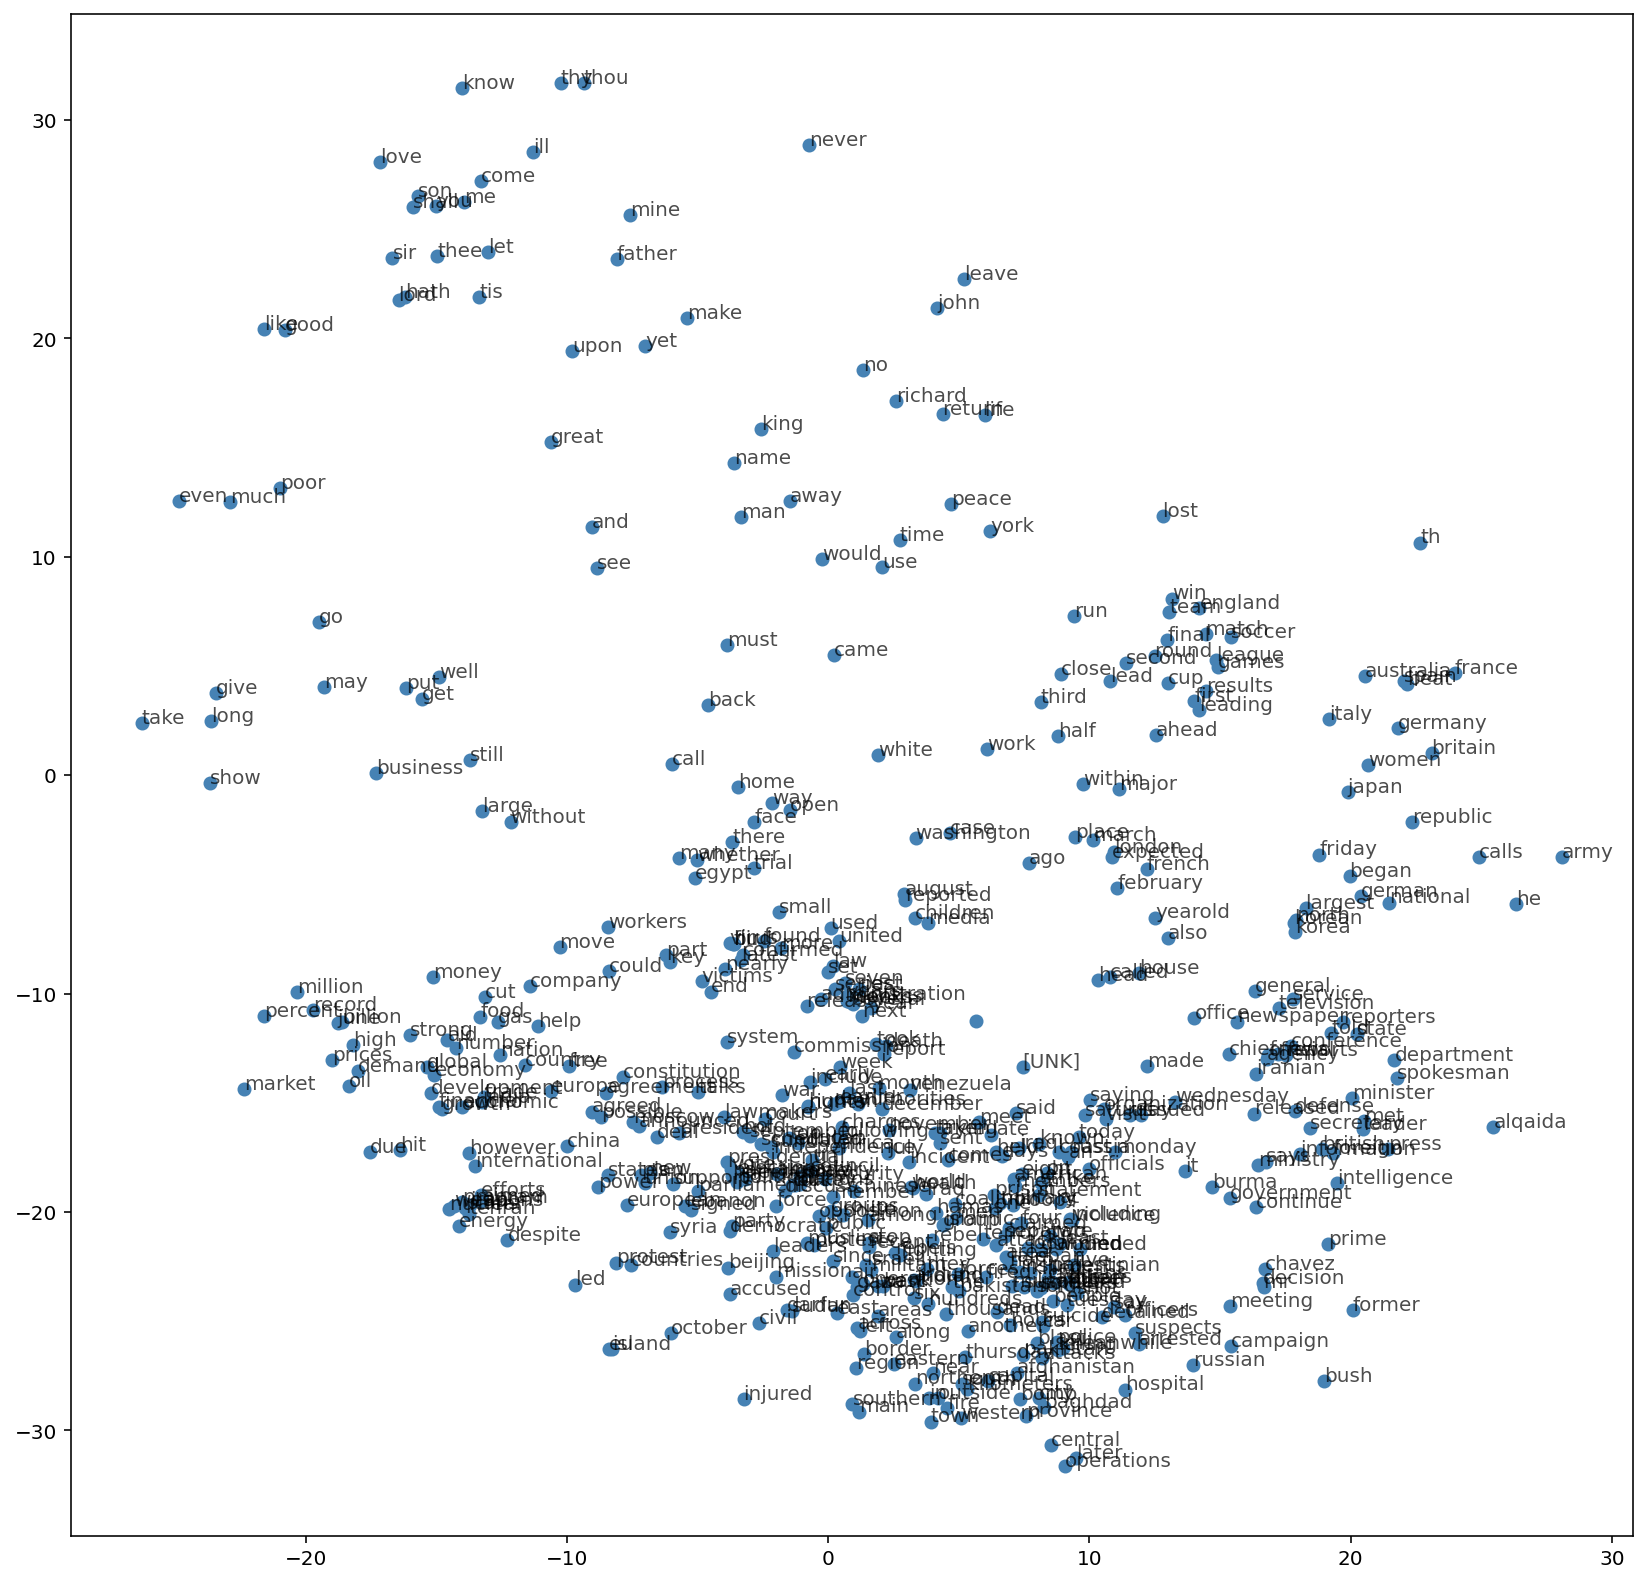

In [ ]:
# Old embeddings without extra knowledge
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(inverse_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

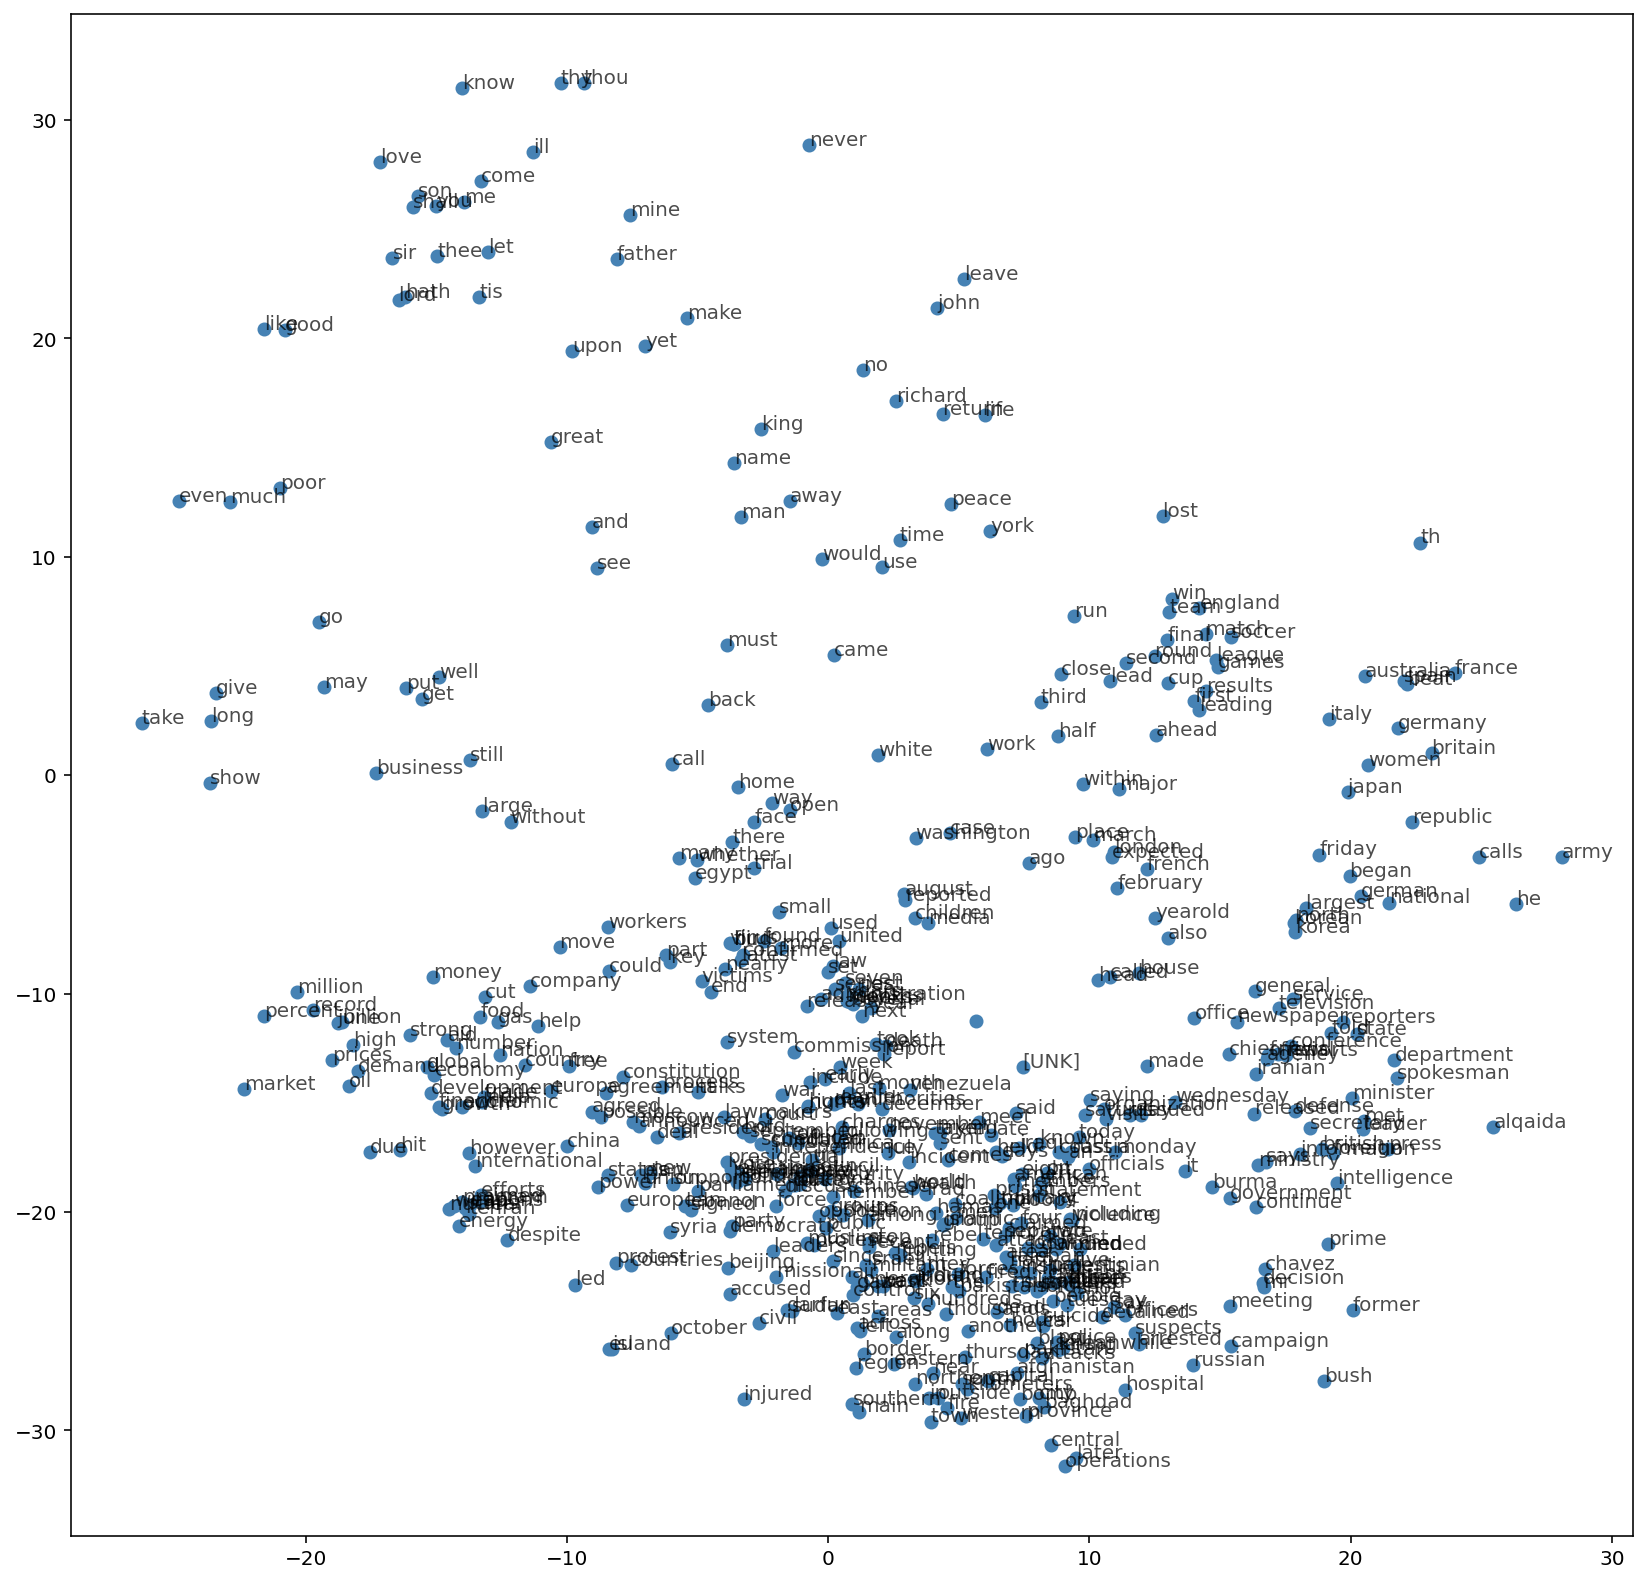

In [ ]:
# New embeddings with extra knowledge
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(inverse_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Create and save the vectors and metadata file.
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
embeddings_file = io.open('embeddings.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  embeddings_file.write(word + '\t' + '\t'.join([str(x) for x in vec]) + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()
embeddings_file.close()

Download the vectors.tsv and metadata.tsv to analyze the obtained embeddings in the Embedding Projector.

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('embeddings.tsv')
  files.download('metadata.tsv')
except Exception:
  pass